# 1. Import Library

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torchvision.models import resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device yang digunakan:", device)

Device yang digunakan: cuda


# 2. Early Stopping

In [2]:
class EarlyStopping:
    def __init__(self, patience=7):
        self.patience = patience
        self.best_loss = None
        self.counter = 0

    def step(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


# 3. Dataset Loader

In [3]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_ds = datasets.ImageFolder(r"C:\Users\IKBAR\uap_ML\src\dataset\Coffe_Bean\train", transform)
val_ds   = datasets.ImageFolder(r"C:\Users\IKBAR\uap_ML\src\dataset\Coffe_Bean\val", transform)
test_ds  = datasets.ImageFolder(r"C:\Users\IKBAR\uap_ML\src\dataset\Coffe_Bean\test", transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)

class_names = train_ds.classes

# 4. Model MobileNetV2

# a. Model

In [4]:
from torchvision.models import mobilenet_v2

model = mobilenet_v2(pretrained=True)
for param in model.features.parameters():
    param.requires_grad = False

model.classifier[1] = nn.Linear(model.classifier[1].in_features, 4)
model = model.to(device)

c:\Users\IKBAR\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\IKBAR\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# b. Training

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
early_stop = EarlyStopping()

train_loss, val_loss, train_acc, val_acc = [], [], [], []

for epoch in range(50):
    model.train()
    correct = total = loss_sum = 0

    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        correct += (out.argmax(1)==y).sum().item()
        total += y.size(0)

    train_loss.append(loss_sum/len(train_loader))
    train_acc.append(correct/total)

    model.eval()
    correct = total = loss_sum = 0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out,y)

            loss_sum += loss.item()
            correct += (out.argmax(1)==y).sum().item()
            total += y.size(0)

    val_loss.append(loss_sum/len(val_loader))
    val_acc.append(correct/total)

    print(f"Epoch {epoch+1} | Train Acc {train_acc[-1]:.4f} | Train Loss {train_loss[-1]:.4f} | Val Acc {val_acc[-1]:.4f} | Val Loss {val_loss[-1]:.4f}")

    if early_stop.step(val_loss[-1]):
        print("Early stopping")
        break

Epoch 1 | Train Acc 0.5936 | Train Loss 1.1020 | Val Acc 0.8975 | Val Loss 0.7862
Epoch 2 | Train Acc 0.8729 | Train Loss 0.6808 | Val Acc 0.9250 | Val Loss 0.5449
Epoch 3 | Train Acc 0.9186 | Train Loss 0.4900 | Val Acc 0.9575 | Val Loss 0.4076
Epoch 4 | Train Acc 0.9274 | Train Loss 0.3980 | Val Acc 0.9650 | Val Loss 0.3246
Epoch 5 | Train Acc 0.9374 | Train Loss 0.3353 | Val Acc 0.9800 | Val Loss 0.2605
Epoch 6 | Train Acc 0.9490 | Train Loss 0.2877 | Val Acc 0.9750 | Val Loss 0.2223
Epoch 7 | Train Acc 0.9512 | Train Loss 0.2588 | Val Acc 0.9850 | Val Loss 0.1992
Epoch 8 | Train Acc 0.9526 | Train Loss 0.2395 | Val Acc 0.9800 | Val Loss 0.1759
Epoch 9 | Train Acc 0.9493 | Train Loss 0.2242 | Val Acc 0.9850 | Val Loss 0.1633
Epoch 10 | Train Acc 0.9569 | Train Loss 0.2048 | Val Acc 0.9850 | Val Loss 0.1524
Epoch 11 | Train Acc 0.9538 | Train Loss 0.1992 | Val Acc 0.9850 | Val Loss 0.1346
Epoch 12 | Train Acc 0.9631 | Train Loss 0.1763 | Val Acc 0.9850 | Val Loss 0.1254
Epoch 13 | Tr

# 5. Evaluasi & Visualisasi

## a. Classification Report

In [6]:
y_true, y_pred = [], []
model.eval()

with torch.no_grad():
    for x,y in test_loader:
        out = model(x.to(device))
        y_true.extend(y.numpy())
        y_pred.extend(out.argmax(1).cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        Dark       1.00      1.00      1.00       100
       Green       1.00      1.00      1.00       100
       Light       1.00      1.00      1.00       100
      Medium       1.00      1.00      1.00       100

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



## b. Grafik Loss & Accuracy

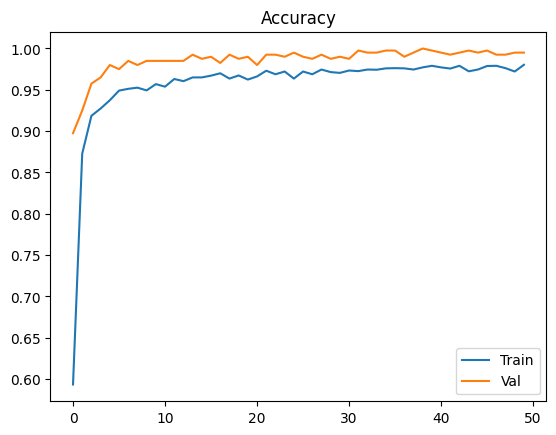

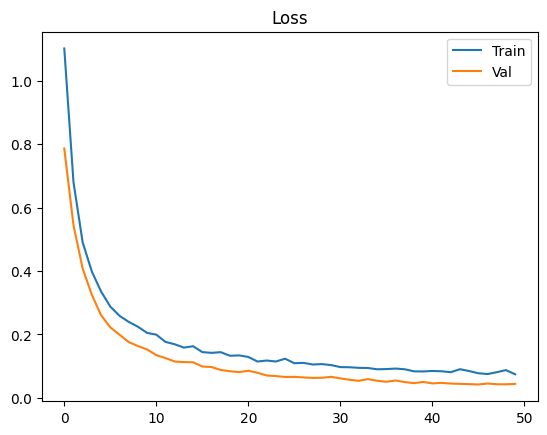

In [7]:
plt.plot(train_acc,label="Train")
plt.plot(val_acc,label="Val")
plt.title("Accuracy")
plt.legend()
plt.show()

plt.plot(train_loss,label="Train")
plt.plot(val_loss,label="Val")
plt.title("Loss")
plt.legend()
plt.show()


## c. Confusion Matrix

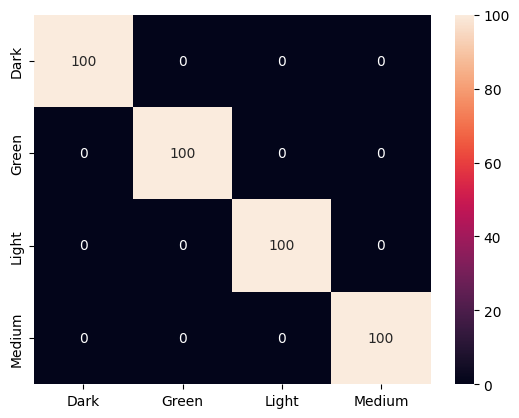

In [8]:
cm = confusion_matrix(y_true,y_pred)
sns.heatmap(cm,annot=True,fmt='d',xticklabels=class_names,yticklabels=class_names)
plt.show()

In [9]:
torch.save(model.state_dict(), r"C:\Users\IKBAR\uap_ML\src\model\mobilenetv2.pkl")